In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -q kaggle
!mkdir ~/.kaggle

In [6]:
! cp "/content/drive/MyDrive/Colab Notebooks/Thesis/kaggle.json"  ~/.kaggle

In [8]:
!kaggle datasets download -d sunray2333/whurs191

 91% 84.0M/92.2M [00:01<00:00, 82.5MB/s]
100% 92.2M/92.2M [00:01<00:00, 87.7MB/s]


In [9]:
! cp "/content/whurs191.zip" "/content/drive/MyDrive/Colab Notebooks/Thesis"

In [2]:
# ! unzip -q "/content/drive/MyDrive/Colab Notebooks/Thesis/eurosat-dataset.zip"
# ! unzip -q "/content/drive/MyDrive/Colab Notebooks/Thesis/landuse-scene-classification.zip"
# ! unzip -q "/content/drive/MyDrive/Colab Notebooks/Thesis/NWPU-RESISC45.zip"
# ! unzip -q "/content/drive/MyDrive/Colab Notebooks/Thesis/PatternNet.zip"
! unzip -q "/content/drive/MyDrive/Colab Notebooks/Thesis/WHU-RS19.zip"

In [3]:
datasets_dir =  "/content/WHU-RS19"

In [4]:
IMG_SIZE = 128
BATCH_SIZE = 32
epochs = 20

In [5]:
import tensorflow as tf
tf.random.set_seed(42)

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = datasets_dir,
    image_size = (IMG_SIZE, IMG_SIZE),
    label_mode = 'categorical',
    color_mode="rgb",
    batch_size = BATCH_SIZE,
    seed=42,
    shuffle = True,
    validation_split=0.2,
    subset="training"

).prefetch(buffer_size=tf.data.AUTOTUNE)


test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = datasets_dir,
    image_size =  (IMG_SIZE, IMG_SIZE),
    label_mode = 'categorical',
    color_mode="rgb",
    batch_size = BATCH_SIZE,
    seed=42,
    shuffle = True,
    validation_split=0.2,
    subset="validation"

)
class_names = test_dataset.class_names
test_data = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
# test_data = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
class_names


Found 1048 files belonging to 19 classes.
Using 839 files for training.
Found 1048 files belonging to 19 classes.
Using 209 files for validation.


['Airport',
 'Beach',
 'Bridge',
 'Commercial',
 'Desert',
 'Farmland',
 'FootballField',
 'Forest',
 'Highway',
 'Industrial',
 'Meadow',
 'Mountain',
 'Park',
 'ParkingLot',
 'Pond',
 'Port',
 'RailwayStation',
 'Residential',
 'River']

In [6]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)
], name ="data_augmentation")

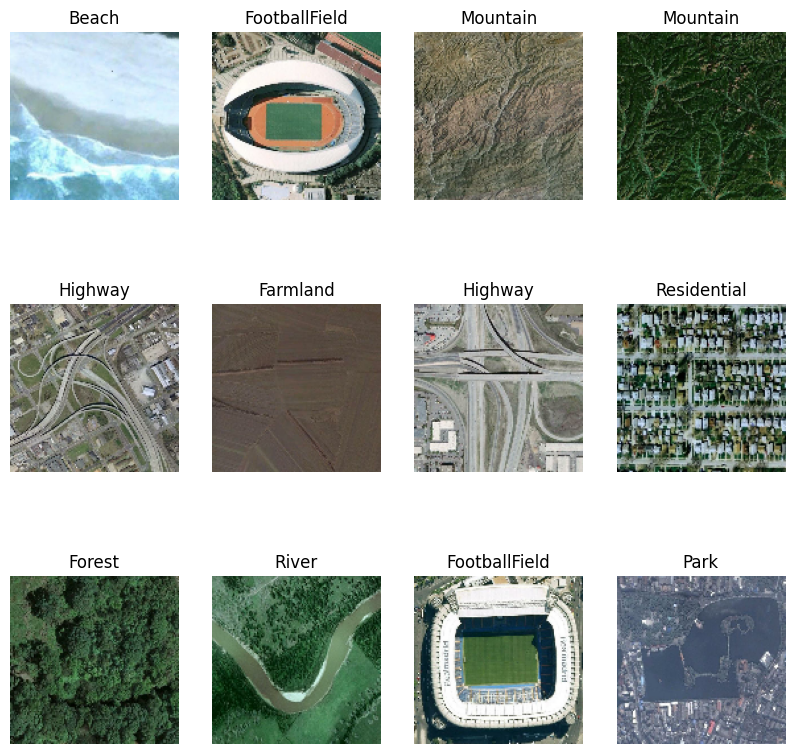

In [7]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(10,10))

for image_batch,label_batch in train_data.take(1):
    for i in range(0,12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")

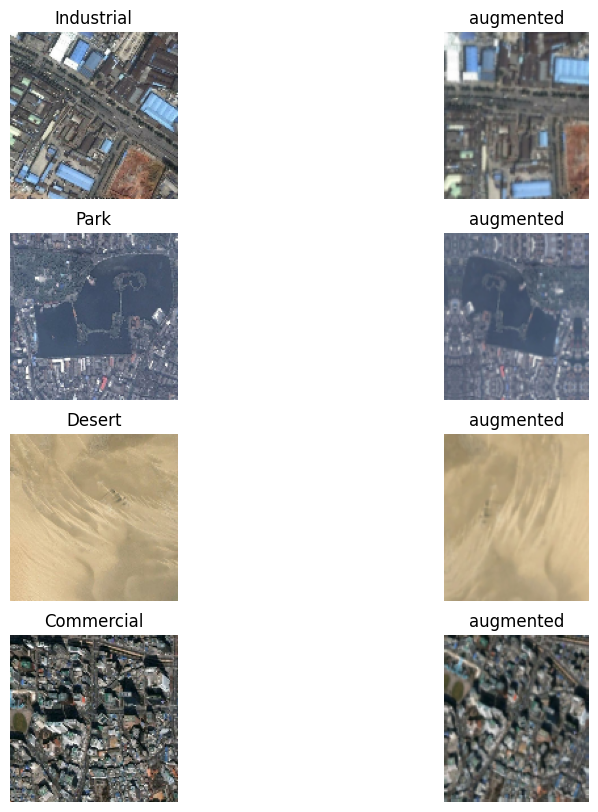

In [8]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in train_data.take(1):
    augmented_image_batch = data_augmentation(image_batch)
    image_plt_len = len(image_batch) if len(image_batch) < 4 else 4
    for i in range(0, image_plt_len):
        plt.subplot(image_plt_len,2,2*i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")
        plt.subplot(image_plt_len,2,2*i+2)
        img = augmented_image_batch[i]
        img = np.array(img, dtype=np.int32)
        plt.imshow(img)
        plt.title(f"augmented")
        plt.axis("off")

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, None, None, 3)        0         ['input_layer[0][0]']         
 ial)                                                                                             
                                                                                                  
 efficientnetb0 (Functional  (None, None, None, 1280)     4049571   ['data_augmentation[0][0]']   
 )                                                                                                
                             

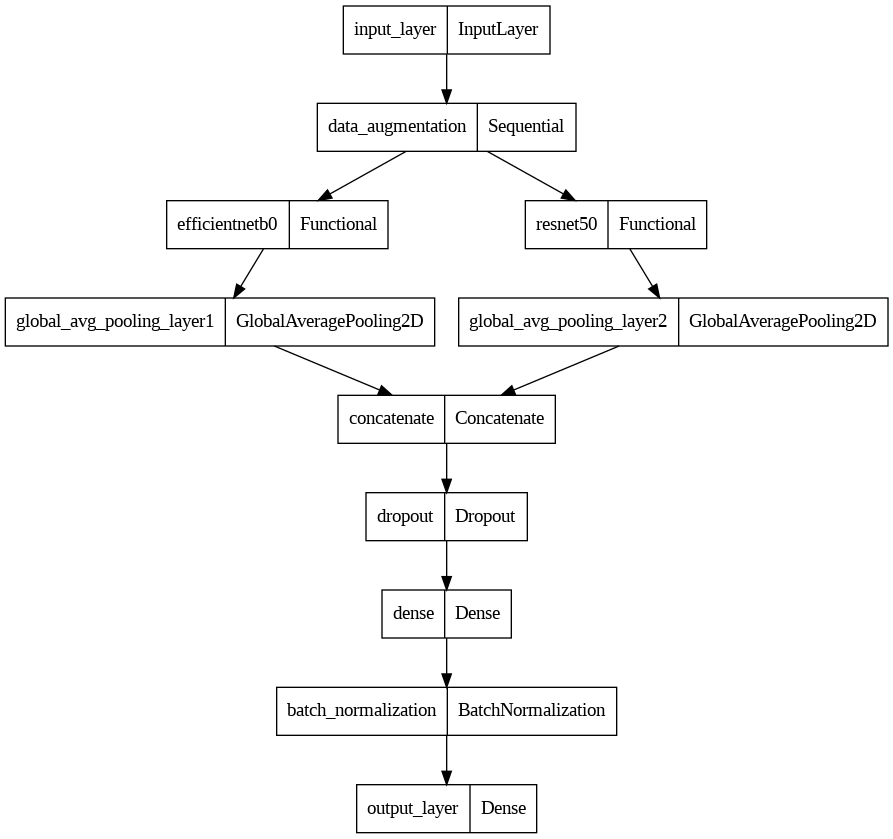

In [9]:
import tensorflow as tf

# Setup the base models and freeze their layers (this will extract features)
base_model1 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model2 = tf.keras.applications.ResNet50(include_top=False)

base_model1.trainable = True  # Enable fine-tuning
base_model2.trainable = True  # Enable fine-tuning

# Fine-tune only the last N layers
fine_tune_at = 50
for layer in base_model1.layers[:-fine_tune_at]:
    layer.trainable = False

fine_tune_at = 20
for layer in base_model2.layers[:-fine_tune_at]:
    layer.trainable = False

# Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_layer')
x = data_augmentation(inputs)
x1 = base_model1(x, training=False)
x2 = base_model2(x, training=False)
x1 = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer1')(x1)
x2 = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer2')(x2)
x = tf.keras.layers.concatenate([x1, x2])


x = tf.keras.layers.Dropout(0.4)(x)  # Adjust dropout rate
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Add dense layer with L2 regularization
x = tf.keras.layers.BatchNormalization()(x)  # Add batch normalization
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Adjust the learning rate
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

# Learning rate schedule callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

model.summary()
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    dpi=96,
)


In [10]:
# Train the model with the learning rate schedule
history = model.fit(
    train_data,
    epochs=epochs,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
27/27 [==============================] - 71s 2s/step - loss: 6.8855 - accuracy: 0.3826 - val_loss: 6.5712 - val_accuracy: 0.4737 - lr: 1.0000e-04
Epoch 2/20
27/27 [==============================] - 25s 904ms/step - loss: 5.4108 - accuracy: 0.7747 - val_loss: 5.3167 - val_accuracy: 0.7751 - lr: 1.0000e-04
Epoch 3/20
27/27 [==============================] - 23s 853ms/step - loss: 4.9678 - accuracy: 0.8605 - val_loss: 5.0130 - val_accuracy: 0.8230 - lr: 1.0000e-04
Epoch 4/20
27/27 [==============================] - 18s 639ms/step - loss: 4.6701 - accuracy: 0.9190 - val_loss: 4.7680 - val_accuracy: 0.8230 - lr: 1.0000e-04
Epoch 5/20
27/27 [==============================] - 17s 575ms/step - loss: 4.4670 - accuracy: 0.9356 - val_loss: 4.6594 - val_accuracy: 0.8565 - lr: 1.0000e-04
Epoch 6/20
27/27 [==============================] - 13s 468ms/step - loss: 4.3195 - accuracy: 0.9476 - val_loss: 4.4475 - val_accuracy: 0.8804 - lr: 1.0000e-04
Epoch 7/20
27/27 [=========================

In [11]:
# Evaluate the model on both training and testing sets
model.evaluate(train_data), model.evaluate(test_data)

7/7 [==============================] - 1s 56ms/step - loss: 4.2274 - accuracy: 0.9187


([4.080407619476318, 0.959475576877594],
 [4.227441310882568, 0.9186602830886841])

In [12]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize=(12,6))
  # Plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

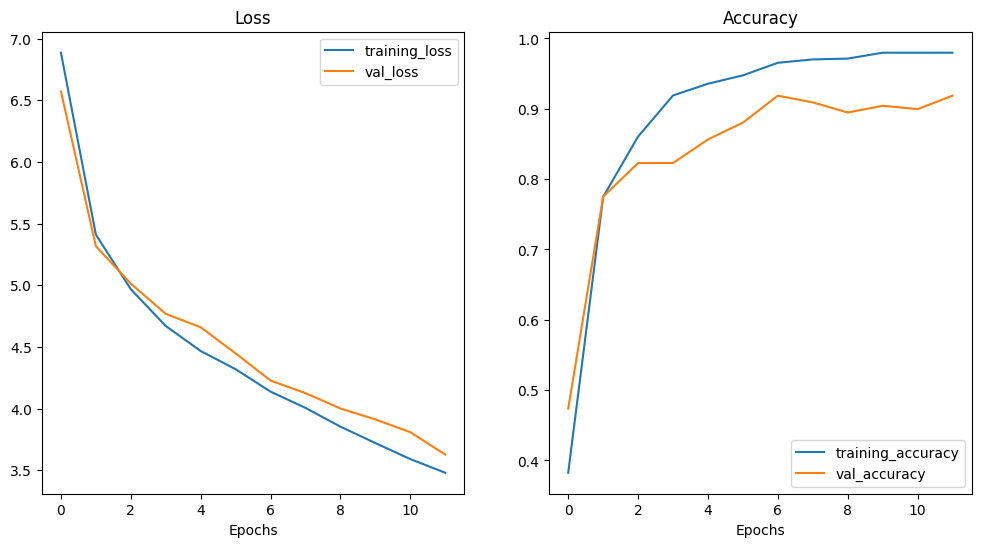

In [13]:
plot_loss_curves(history)

In [14]:
from sklearn.metrics import classification_report

# Evaluate the model on the test set
y_true = np.array([])
y_pred = np.array([])
for x, y in test_data:
    y_true = np.concatenate([y_true, np.argmax(y, axis=-1)], axis=0)
    y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis=-1)], axis=0)

# Display classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)

1/1 [==============================] - 3s 3s/step
Classification Report:
                 precision    recall  f1-score   support

       Airport       0.92      0.85      0.88        13
         Beach       1.00      1.00      1.00         8
        Bridge       1.00      1.00      1.00         7
    Commercial       0.88      0.70      0.78        10
        Desert       1.00      1.00      1.00        10
      Farmland       0.88      1.00      0.93         7
 FootballField       1.00      1.00      1.00         7
        Forest       0.76      1.00      0.87        13
       Highway       1.00      0.90      0.95        10
    Industrial       0.92      0.85      0.88        13
        Meadow       1.00      0.64      0.78        14
      Mountain       1.00      1.00      1.00         5
          Park       1.00      0.80      0.89        10
    ParkingLot       0.86      1.00      0.92        12
          Pond       0.93      0.93      0.93        14
          Port       1.00    

Class counts: [12  8  7  8 10  7  7 13  9 13]


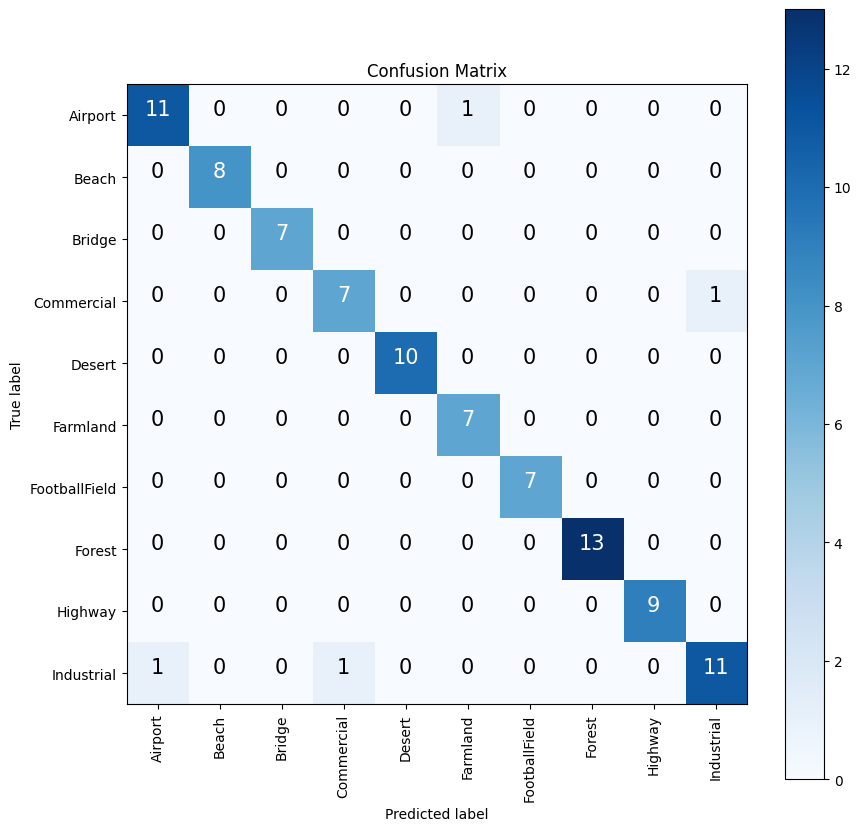

In [15]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False):

    # Create the confusion matrix for the selected classes
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Select only the first 10 classes
    conf_matrix_subset = conf_matrix[:10, :10]

    # Print the sum of instances for each class
    print("Class counts:", np.sum(conf_matrix_subset, axis=1))

    # Normalize the confusion matrix if specified
    if norm:
        conf_matrix_norm = conf_matrix_subset.astype("float") / conf_matrix_subset.sum(axis=1)[:, np.newaxis]
    else:
        conf_matrix_norm = None

    n_classes = conf_matrix_subset.shape[0]

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(conf_matrix_subset, cmap=plt.cm.Blues)  # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes[:n_classes]
    else:
        labels = np.arange(n_classes)

    # Label the axes
    ax.set(
        title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),  # create enough axis slots for each class
        yticks=np.arange(n_classes),
        xticklabels=labels,  # axes will be labeled with class names (if they exist) or ints
        yticklabels=labels,
    )

    # Make x-axis labels appear on bottom
    ax.tick_params(axis='x', labelrotation=90)
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (conf_matrix_subset.max() + conf_matrix_subset.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(conf_matrix_subset.shape[0]), range(conf_matrix_subset.shape[1])):
        if norm:
            plt.text(j, i, f"{conf_matrix_subset[i, j]} ({conf_matrix_norm[i, j]*100:.1f}%)",
                     horizontalalignment="center",
                     color="white" if conf_matrix_subset[i, j] > threshold else "black",
                     size=text_size)
        else:
            plt.text(j, i, f"{conf_matrix_subset[i, j]}",
                     horizontalalignment="center",
                     color="white" if conf_matrix_subset[i, j] > threshold else "black",
                     size=text_size)

# Assuming y_true and y_pred have been calculated
y_true_subset = y_true[y_true < 10]
y_pred_subset = y_pred[y_true < 10]

# Assuming class_names is defined
make_confusion_matrix(y_true_subset, y_pred_subset, classes=class_names[:32])
plt.show()


1/1 [==============================] - 0s 33ms/step


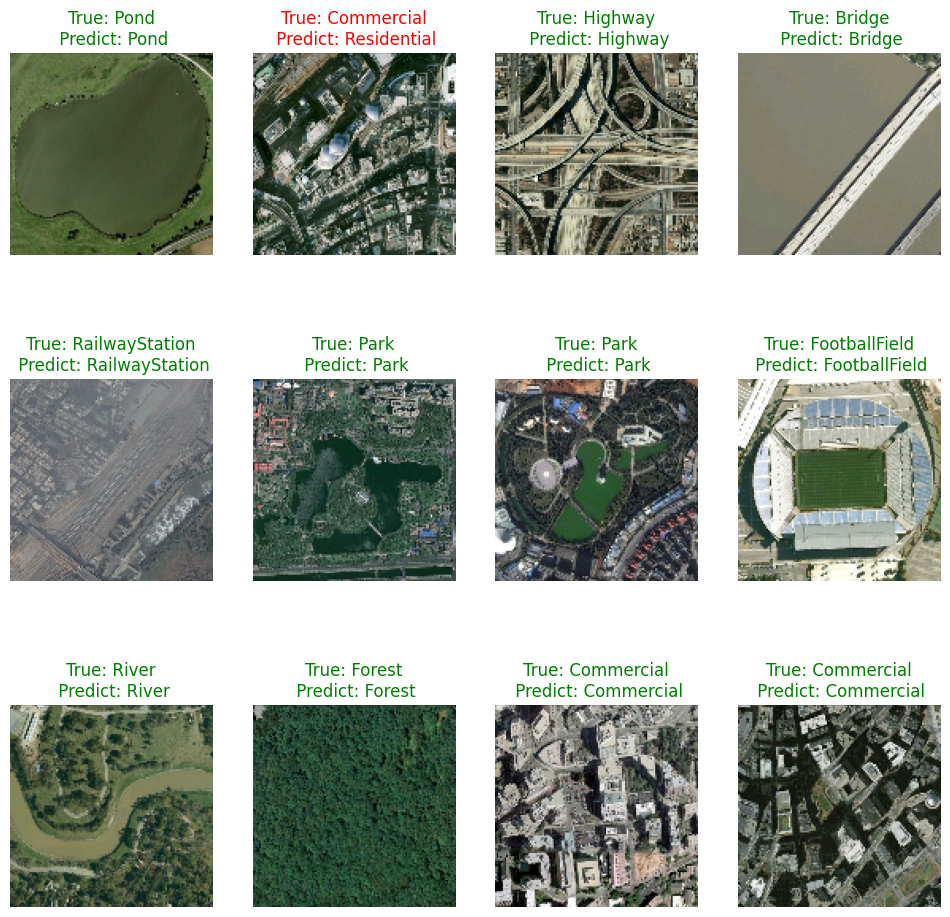

In [16]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,12))
for image_batch,label_batch in test_data.take(1):
    predictions = model.predict(image_batch)
    predictions = np.argmax(predictions, axis=-1)
    for i in range(0,len(predictions) if len(predictions)<12 else 12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        true_class = class_names[np.argmax(label_batch[i])]
        predict_class = class_names[predictions[i]]
        title = f"""True: {true_class}\n Predict: {predict_class}"""
        plt.title(title, color='g' if true_class==predict_class else 'r')
        plt.axis("off")